In [1]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn import tree
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

# Librerías adicionales
import itertools  # Para generar combinaciones de columnas
import matplotlib.patches as mpatches  # Para manejar gráficos

# Importación de módulo personalizado
import payments_manager as pm

# Inicialización del proyecto (si es necesario)
# pm.help()  # Si se necesita ayuda del módulo
# pm.reset()  # Para reiniciar cualquier configuración anterior
# pm.init()  # Si es necesario inicializar el módulo con opciones (por ejemplo, debug=True)

# Cargar y preparar el DataFrame df_jo
df_jo = pm.df('df_jo')  # Cargar el DataFrame desde 'payments_manager'
df_jo.info()  # Ver información básica sobre el DataFrame

# Ordenar el DataFrame df_jo por la columna 'id_cr' y resetear índices
df_jo = df_jo.sort_values(by=["id_cr"]).reset_index(drop=True)

# Crear una copia del DataFrame para su posterior uso
df_jo_cp = df_jo.copy()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

In [2]:
# PASAJE DE CATEGORICAS A NUMERICAS

# Reasignar valores en la columna 'transfer_type'
df_jo_cp['transfer_type'] = df_jo_cp['transfer_type'].map({'regular': 0, 'instant': 1})
df_jo_cp['charge_moment'] = df_jo_cp['charge_moment'].map({'before': 0, 'after': 1})

In [3]:
# SEGMENTACIONES EN DATAFRAMES REPETITIVOS Y NUEVOS

# Ordenar por 'created_at' para asegurar que la primera acción esté en la parte superior
df_jo_cp_sorted = df_jo_cp.sort_values('created_at')
count_all = df_jo_cp_sorted.shape[0]

# 2. Identificar usuarios con más de una acción (usuarios repetitivos)

repeat_users_df = df_jo_cp[(df_jo_cp['n_fees'] > 1) | (df_jo_cp['n_backs'] > 1) | (df_jo_cp['n_recovery'] > 1) | (df_jo_cp['n_incidents'] > 1)]

# Sort and group by user_id, keeping repetitive activities
repeat_users_df = repeat_users_df.sort_values('created_at').reset_index(drop=True)

# Obtener los usuarios nuevos (aquellos con solo una acción)

new_users_df = df_jo_cp[(df_jo_cp['n_fees'] <= 1) & (df_jo_cp['n_backs'] <= 1) & (df_jo_cp['n_recovery'] <= 1) & (df_jo_cp['n_incidents'] <= 1)]


new_users_df = new_users_df.sort_values('created_at').groupby('user_id').first().reset_index()

# Número de filas de nuevos usuarios
count_new_users = new_users_df.shape[0]

# Número de filas de usuarios repetitivos
count_repeat_users = repeat_users_df.shape[0]

# Imprimir resultados
print(f'Número de filas en el DataFrame original: {count_all}')
print(f'Número de filas en el DataFrame de nuevos usuarios: {count_new_users}')
print(f'Número de filas en el DataFrame de usuarios repetitivos: {count_repeat_users}')

repeat_users_df

Número de filas en el DataFrame original: 32092
Número de filas en el DataFrame de nuevos usuarios: 11938
Número de filas en el DataFrame de usuarios repetitivos: 19078


,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,stat_cr,...,n_incidents,created_at_w,n_cr_fe_w,created_at_m,n_cr_fe_m,created_at_d,GBP_EUR,BTC_GBP,inflation,unemploy_rate
0,118,0,NaN,47,1,2019-12-12 14:14:14.131479,NaT,100.0,0.0,rejected,...,2,50,NaN,12,NaN,2019-12-12,1.18557,5376.049805,1.3,4.0
1,255,0,NaN,1286,1,2019-12-19 16:17:15.557171,NaT,100.0,0.0,rejected,...,2,51,NaN,12,NaN,2019-12-19,1.17670,5532.994629,1.3,4.0
2,270,0,NaN,1003,1,2019-12-20 23:24:54.262779,NaT,50.0,0.0,rejected,...,2,51,NaN,12,NaN,2019-12-20,1.17000,5551.017090,1.3,4.0
3,275,0,NaN,674,1,2019-12-21 11:22:04.818452,NaT,50.0,0.0,direct_debit_rejected,...,2,51,NaN,12,NaN,2019-12-21,0.00000,5529.749023,1.3,4.0
4,277,0,NaN,792,1,2019-12-21 12:19:28.165381,NaT,50.0,0.0,rejected,...,2,51,NaN,12,NaN,2019-12-21,0.00000,5529.749023,1.3,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19073,27003,21173,27003.0,87631,1,2020-11-01 22:52:41.631946,2020-11-01 22:52:58.077068,50.0,5.0,money_back,...,0,44,1.0,11,1.0,2020-11-01,0.00000,10627.522461,0.7,5.3
19074,27004,21175,27004.0,53150,1,2020-11-01 22:58:58.091762,2020-11-01 22:59:06.873413,25.0,5.0,money_back,...,0,44,1.0,11,1.0,2020-11-01,0.00000,10627.522461,0.7,5.3
19075,27006,21181,27006.0,55916,1,2020-11-01 23:07:55.231487,2020-11-01 23:08:17.050811,50.0,5.0,money_back,...,1,44,1.0,11,1.0,2020-11-01,0.00000,10627.522461,0.7,5.3
19076,27007,21182,27007.0,39339,1,2020-11-01 23:11:37.788849,2020-11-01 23:12:30.916635,100.0,5.0,money_back,...,0,44,1.0,11,1.0,2020-11-01,0.00000,10627.522461,0.7,5.3


In [4]:
#VERIFICACION DE BALANCEO DE CLASES

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts_all = df_jo_cp['needs_m_check_recov'].value_counts()
value_counts_new = new_users_df['needs_m_check_recov'].value_counts()
value_counts_rep = repeat_users_df['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total_all = value_counts_all[0] + value_counts_all[1]
total_new = value_counts_new[0] + value_counts_new[1]
total_rep = value_counts_rep[0] + value_counts_rep[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual_all = (value_counts_all[1] / total_all) * 100
needs_manual_new = (value_counts_new[1] / total_new) * 100
needs_manual_rep = (value_counts_rep[1] / total_rep) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes nuevos: {needs_manual_new:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes repetitivos: {needs_manual_rep:.2f} %')

Porcentaje de operaciones con needs_m_check del total de clientes: 52.31 %
Porcentaje de operaciones con needs_m_check del clientes nuevos: 43.83 %
Porcentaje de operaciones con needs_m_check del clientes repetitivos: 58.42 %


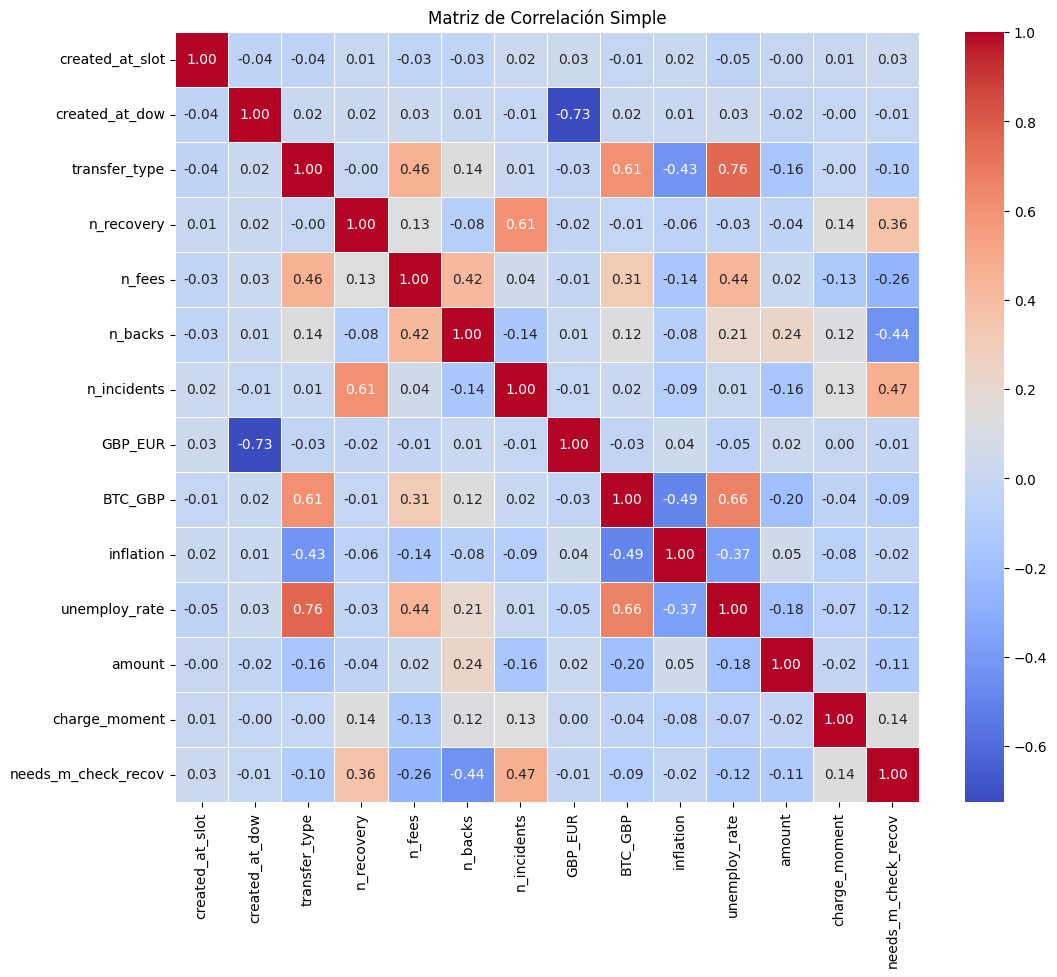

In [5]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type','n_recovery', 'n_fees', 'n_backs','n_incidents','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment','needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
#df_simpl = df_jo_cp_sorted[columnas_deseadas]
#df_simpl = new_users_df[columnas_deseadas]
df_simpl = repeat_users_df[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()


In [13]:
# BALANCEO DE CARGAS

columns = df_simpl.columns
X_b = df_simpl.drop('needs_m_check_recov', axis=1)
y_b = df_simpl['needs_m_check_recov']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X_b, y_b)

columns_X = np.delete(columns, 13)
columns_y = columns[-1]

print(pd.Series(y_under).value_counts())

X_b_df = pd.DataFrame(X_under, columns=columns_X)
y_b_df = pd.DataFrame(y_under, columns=[columns_y])

balanced_df = pd.concat([X_b_df, y_b_df], axis=1)

needs_m_check_recov
0    7933
1    7933
Name: count, dtype: int64


In [16]:
# NORMALIZACION Y ESCALADO

# Eliminar las columnas no necesarias del DataFrame
X_s = balanced_df.drop(columns=[
    'needs_m_check_recov',
])

# Definir la variable objetivo
Y_s = balanced_df['needs_m_check_recov']

# Aplicar StandardScaler para la normalización
s_scaler = StandardScaler()
X_s_scaled = s_scaler.fit_transform(X_s)

# Convertir el array escalado de nuevo a DataFrame y restaurar los nombres de las columnas
X_s_scaled = pd.DataFrame(X_s_scaled, columns=X_s.columns)

# Imprimir las formas de los datos
print(X_s_scaled.shape)
print(Y_s.shape)

(15866, 13)
(15866,)


In [17]:
# PREPARACION DE CARACTERISTICAS Y ETIQUETA PARA MODELOS

# Crea la matriz de características y la var objetivo
#X = df_simpl.drop(columns=[
#    'needs_m_check_recov',  
    #'created_at_slot',      
    #'created_at_dow',       
    #'transfer_type',
    #'n_fees',
    #'n_backs',
    #'n_incidents',
    #'GBP_EUR',
    #'BTC_GBP',
    #'inflation',      
    #'unemploy_rate',
    #'amount',
    #'charge_moment"
#])

X = X_s


#y = df_simpl['needs_m_check_recov'] # La columna de la variable objetivo
y = Y_s
y.shape



(15866,)

In [18]:
# MODELO DE ÁRBOL DE DECISIÓN/RANDOM FOREST

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de Árbol de Decisión
#DT = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=None)
RF = RandomForestClassifier(min_samples_leaf=10, max_depth=None)

# Entrenar el modelo con el conjunto de datos de entrenamiento
#DT.fit(X_train, y_train)
RF.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
#predictions = DT.predict(X_test)
predictions = RF.predict(X_test)



In [19]:
# Importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': RF.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

            Feature  Importance
6       n_incidents    0.385579
3        n_recovery    0.176200
5           n_backs    0.173225
4            n_fees    0.074647
12    charge_moment    0.070699
8           BTC_GBP    0.025322
10    unemploy_rate    0.020620
7           GBP_EUR    0.014676
11           amount    0.014478
2     transfer_type    0.013863
9         inflation    0.012699
0   created_at_slot    0.011378
1    created_at_dow    0.006614


Precisión del modelo: 0.9246

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      2390
           1       0.92      0.93      0.92      2370

    accuracy                           0.92      4760
   macro avg       0.92      0.92      0.92      4760
weighted avg       0.92      0.92      0.92      4760


Importancia de las características (ordenadas por magnitud):
n_incidents: 0.3856
n_recovery: 0.1762
n_backs: 0.1732
n_fees: 0.0746
charge_moment: 0.0707
BTC_GBP: 0.0253
unemploy_rate: 0.0206
GBP_EUR: 0.0147
amount: 0.0145
transfer_type: 0.0139
inflation: 0.0127
created_at_slot: 0.0114
created_at_dow: 0.0066


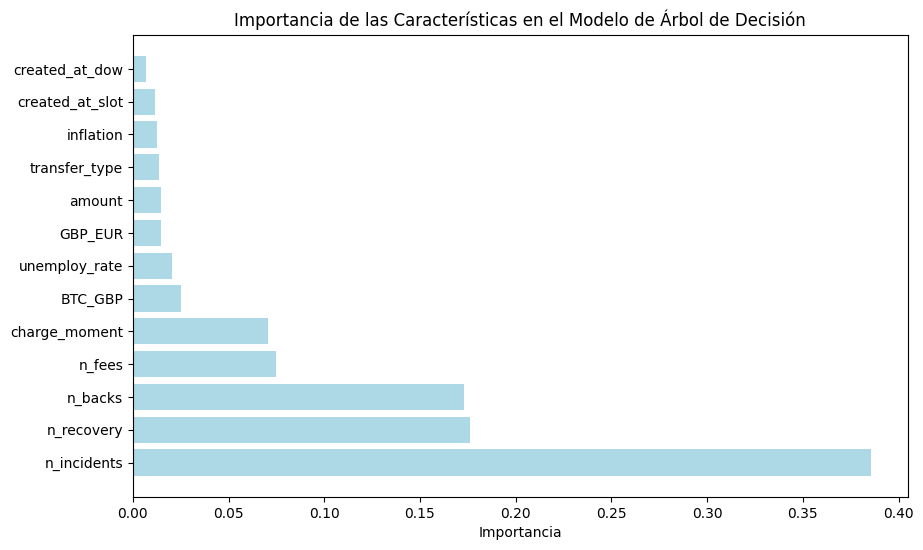

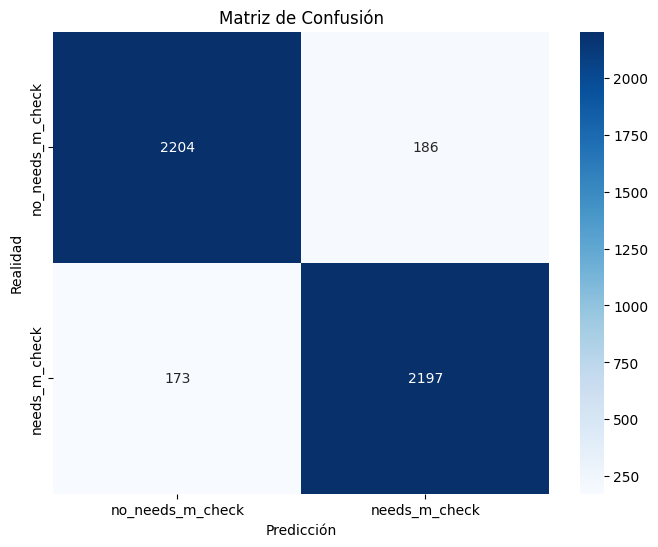

In [20]:
# EVALUACION DEL RENDIMIENTO DEL MODELO

# 1. Precisión del modelo
accuracy = RF.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(y_test, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = RF.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
# Graficar las importancias de las características (ordenadas)
features = [f[0] for f in feature_importance_sorted]
importances = [f[1] for f in feature_importance_sorted]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()


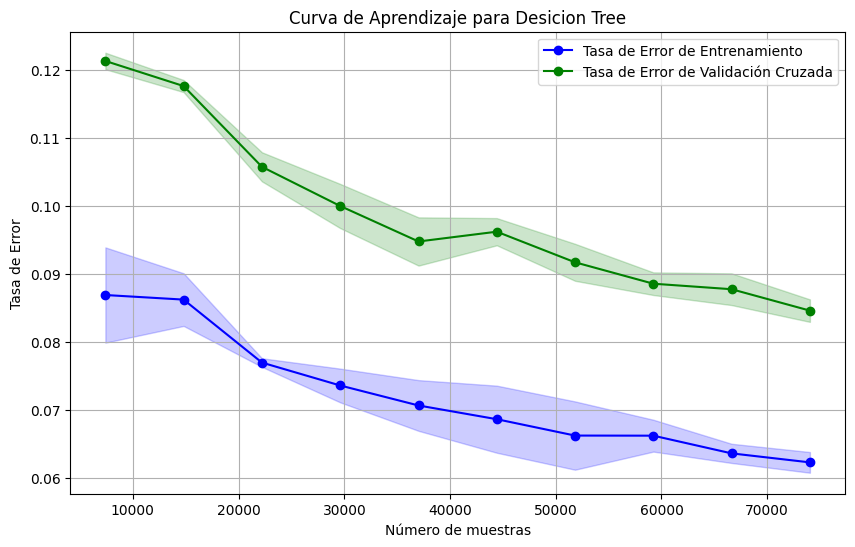

In [21]:
# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    RF, X_train, y_train, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calcular la media y desviación estándar de las puntuaciones de entrenamiento y validación
train_mean = np.mean(train_scores, axis=1)  # Media de las puntuaciones de entrenamiento
train_std = np.std(train_scores, axis=1)    # Desviación estándar de las puntuaciones de entrenamiento
test_mean = np.mean(test_scores, axis=1)   # Media de las puntuaciones de validación
test_std = np.std(test_scores, axis=1)     # Desviación estándar de las puntuaciones de validación

# Conversión a tasa de error (1 - precisión)
train_error = 1 - train_mean
test_error = 1 - test_mean

# 5. Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura
plt.plot(train_sizes * 10, train_error, 'o-', color="blue", label="Tasa de Error de Entrenamiento")  # Tasa de error en entrenamiento
plt.plot(train_sizes * 10, test_error, 'o-', color="green", label="Tasa de Error de Validación Cruzada")  # Tasa de error en validación cruzada
plt.fill_between(
    train_sizes * 10, 
    train_error - train_std, 
    train_error + train_std, 
    color="blue", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de entrenamiento
)
plt.fill_between(
    train_sizes * 10, 
    test_error - test_std, 
    test_error + test_std, 
    color="green", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de validación cruzada
)
#plt.title("Curva de Aprendizaje para Random Forest")  # Título del gráfico
plt.title("Curva de Aprendizaje para Desicion Tree")  # Título del gráfico
plt.xlabel("Número de muestras")  # Etiqueta del eje x
plt.ylabel("Tasa de Error")  # Etiqueta del eje y
plt.legend(loc="best")  # Leyenda de la gráfica
plt.grid(True)  # Mostrar cuadrícula
plt.show()  # Mostrar gráfica

 

